In [1]:
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

In [2]:
import impl.layer as l

class GRU:

    def __init__(self, D, H, L, char2idx, idx2char, p_dropout):
        self.D = D
        self.H = H
        self.L = L
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
        self.p_dropout = p_dropout
        
        # Model parameters
        Z = H + D
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.),
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        
        self.model = []
        for _ in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def dropout_forward(self, X, p_dropout):
        u = np.random.binomial(1, p_dropout, size=X.shape) / p_dropout
        # q = 1-p_dropout
        # u = np.random.binomial(1, q, size=X.shape)
        out = X * u
        cache = u
        return out, cache

    def dropout_backward(self, dout, cache):
        dX = dout * cache
        return dX
        
    def forward(self, X, h, m, train):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)

        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        h = h_in + (hz * (hh - h_in))
        # equal to
        # h = (1.0 - hz) * h_in + hz * hh
        # or
        # h = h_in + (hz * hh)
        # or
        # h = h_in + hz
        # or
        # h = h_in + hh

        ## SELU + SELU-Dropout
        #         y, y_cache = l.fc_forward(h, Wy, by)
        #         y, y_selu_cache = self.selu_forward(y)
        #         y = X_in + y
        #         if train: # with Dropout
        #             y, y_do_cache = self.alpha_dropout_fwd(y, self.p_dropout)
        #             cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache, y_do_cache)
        #         else: # no Dropout: testing or validation
        #             cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_selu_cache)
        
        y, y_cache = l.fc_forward(h, Wy, by)
#         y = X_in + y
        
        if train: # with Dropout
            y, y_do_cache = self.dropout_forward(y, self.p_dropout)
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_do_cache)
        else: # no Dropout: testing or validation
            cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache, train):
        if train:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache, y_do_cache = cache
            dy = self.dropout_backward(dout=dy, cache=y_do_cache)
        else:
            h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dy_out = dy.copy()
        dh_out = dh.copy()
        
        dh, dWy, dby = l.fc_backward(dy, y_cache)
        
        dh += dh_out
        dh_in1 = dh * (1.0 - hz) # res

        dhh =  dh * hz
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)
        
        dhz = dh * (hh - h_in)
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)
        
        dX = dXz + dXh
        
        dh_in2 = dX[:, :self.H]
        dh = dh_in1 + dh_in2 # res cells
        
        dX = dX[:, self.H:]
#         dX += dy_out # res layers

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad
    
    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer], train=True)
                caches[layer].append(cache)
                X = y.copy()
            ys.append(y)
            
        return ys, caches

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.cross_entropy(y_pred, y)
            dy = self.dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            
        dXs = []
        for t in reversed(range(len(dys))):
            dy = dys[t]
            for layer in reversed(range(self.L)):
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t], train=True)                
                for key in grad[layer].keys():
                    grads[layer][key] += grad[layer][key]
                dy = dX.copy()
            dXs.append(dX)
                
        return dXs, grads
    
    def test(self, X_seed, h, size):
        chars = [self.idx2char[X_seed]]
        idx_list = list(range(self.vocab_size))
        X = X_seed
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())

        for _ in range(size):
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.0
            X = X_one_hot.reshape(1, -1)
            for layer in range(self.L):
                y, h[layer], _ = self.forward(X, h[layer], self.model[layer], train=False)
                X = y.copy()
                
            prob = l.softmax(y)
            idx = np.random.choice(idx_list, p=prob.ravel())
            chars.append(self.idx2char[idx])
            X = idx

        return ''.join(chars)

    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        for i in range(0, X.shape[0] - minibatch_size +1, 1):
        # for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def adam_rnn(self, X_train, y_train, alpha, mb_size, n_iter, print_after):
        M, R = [], []
         
        # Hidden layers
        for layer in range(nn.L):
            M.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            R.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
         
        beta1 = .99
        beta2 = .999
        eps = 1e-8
        state = self.initial_state()
        smooth_loss = 1.0
        minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=False)

        # Epochs
        for iter in range(1, n_iter + 1):
            # Minibacthes
            for idx in range(len(minibatches)):
                X_mini, y_mini = minibatches[idx]
                ys, caches = self.train_forward(X_mini, state)
                loss, dys = self.loss_function(y_train=y_mini, ys=ys)
                _, grads = self.train_backward(dys, caches)
                self.losses['train'].append(loss)
                smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
                self.losses['smooth train'].append(smooth_loss)

                for layer in range(nn.L):
                    for key in grads[layer].keys(): #key, value: items
                        M[layer][key] = l.exp_running_avg(M[layer][key], grads[layer][key], beta1)
                        R[layer][key] = l.exp_running_avg(R[layer][key], grads[layer][key]**2, beta2)

                        m_k_hat = M[layer][key] / (1. - (beta1**(iter)))
                        r_k_hat = R[layer][key] / (1. - (beta2**(iter)))

                        self.model[layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            # Print loss and test sample
            if iter % print_after == 0:
                print('Iter-{} loss: {:.4f}'.format(iter, loss))
                sample = self.test(X_mini[0], state, size=100)
                print(sample)

Iter-1 loss: 45.5901
iy -oo-yisamNo  ci  scio n lp,leasfdh saise xh ioir e1h eoiI reSbrdstlkldbyvDiIionoet5x rf onoa -erdn
Iter-2 loss: 44.0345
ide   1ryanmttfyt.r deid  rntnnt f.tshhdFedhsi   f ineil tta  n0iea  nwtlwhCtjtasltnGfaahoa v hipnnnk
Iter-3 loss: 45.3869
iSatemmrnic   heonirrotauhtai2nyisl n0etGctet-g aensrersiadsIuei sp o  hfyn ud arug 
 aphdy.  tth iha
Iter-4 loss: 43.6595
ici itvabl iodhft- t opnepl onsl8sl f ,5  Ndtmeftlfen s. lS ea oa uos en aoroLsEshihuhe e0  tbasefphf
Iter-5 loss: 44.5928
iohassft iei tttsnaw roultrNkane Fmy .biuresyn oa tsea  u  ytuni pl rro fl.6isoadenno,io 5ini ndfhr9n
Iter-6 loss: 38.8179
ittetewdtelpbr ph t tsn  ree bmyilodshiatneh lomabaltuto ee Hnost otn,Wnnanetliaeoih p   tophtaiopoo5
Iter-7 loss: 45.4129
inodsdieaasn6p n  crn itbha    tatFycoeutyglmeaiiotpfh loph  atnptdnitno nf o, ftwtrlhJy ensntiptio r
Iter-8 loss: 45.2979
irh aI lepycts a raah cv hNela fLt  t ctnnrfredt eem set ue e dr,rlfera  bnn estnyt 9dsl,e pghI neawr
Iter-9 loss: 44.

Iter-68 loss: 42.3682
ieettlTtran e  o aHnehlladNi  nm y9Edlonenefin   orp   fc n mooostaJiyo,, p  oiatagnsmpsu aotfdp,taid
Iter-69 loss: 44.1125
im eni neo-smrbr rdesueoS r ioitass ti  atala, afad nHeiiwam CetheAH5owtdrnusntt i nr acd-2ohyuon  ne
Iter-70 loss: 44.0578
it-ttste–n A nnneyso lees e ltndteoe6t'ic mynmsaeshctmtecHereaa e "eI rhr snrtba oJtHatalmre hetiSaho
Iter-71 loss: 44.7404
ia hasi,ctgmidhnwtdrl1eforl  neodneuse hcgnaot epnxh  n eee oathludm dha1itildhGw o eo  ntllogmn Dyeo
Iter-72 loss: 44.2395
ii1Tan   yrrfg eanenaes andcat s myihubemm afdatineaJemsAehnofiebesinJW gf nar nr antism iek tNsirwrc
Iter-73 loss: 43.3567
imwee vneJg eran eoetihg krIecace2i" 'i islen1w wWdsesnuhh adra ssla ,l sSudn iaeJaooefW lri dhlyho  
Iter-74 loss: 43.7413
ir nbGlrdx T aeuedelth ienoo-soe Cmapt snntdrltfht Ali  i,imoe1 yee dgaot-eeasnnteerailbteaosplism d 
Iter-75 loss: 44.6724
in  ia tnb ohg1loawhfl mn6ne1fai r,nsdggii1J yrnyseoeaacyo.,ttst v) oor-no p(tariBexatttrpiiliobta,er
Iter-76 

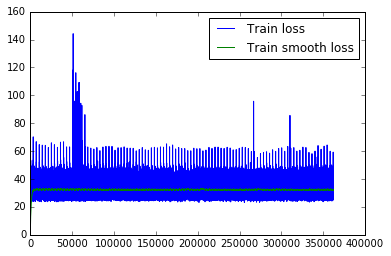

In [3]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 10 # depth
n_iter = 100 # epochs
alpha = 1e-4 # learning_rate
p_dropout = 0.95 # q=1-p, q=keep_prob and p=dropout.
print_after = 1 # n_iter//100 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)

# Build the network and learning it or optimizing it using SGD
nn = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, p_dropout=p_dropout, char2idx=char_to_idx, idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
nn.adam_rnn(X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()